<a href="https://colab.research.google.com/github/PabloViniciusSS/model_ai_medical/blob/main/medical_ai_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import sklearn.metrics
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import io
import glob
import scipy.misc
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import shutil
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib
from tensorflow.keras.optimizers import RMSprop
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg

LEARNING_RATE = 0.0001 #Valor de taxa de aprendizado
repo_url = 'https://github.com/adleberg/medical-ai'        #repositorio com as imagens que serão utilizadas
IMAGE_HEIGHT, IMAGE_WIDTH = 256,256  #tamanho das imagens

def load_image_into_numpy_array(image):       #Converter uma imagem em um array numpy
  image = image.convert('RGB')
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

print("Welcome! Downloading some things... ths will take a minute.")

%cd -q /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url} --quiet
%cd -q {repo_dir_path}
!git pull -q

print("Great! You clicked on it correctly. Now let's get started")

Welcome! Downloading some things... ths will take a minute.
Great! You clicked on it correctly. Now let's get started


In [2]:
finding = "cardiomegaly"
finding = finding.capitalize() #criar modelo usando essa termologia

In [3]:
df = pd.read_csv('/content/medical-ai/labels.csv') #verificando a base de dados
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [4]:
#Definindo os dadoos que procuro e retirando aqueles que não tem classificação
positives = df.loc[df["label"] == finding]
negatives = df.loc[df["label"] == "No Finding"]
n = len(positives)

if n == 0:
  print("No studies found! Maybe check your spelling?")
  assert (n > 0)

In [5]:
#Definindo 80% dos dados para treino e 20% para testes
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
n = len(positives)
TRAIN_N = int(n*TRAIN_RATIO)
TEST_N = int(n*TEST_RATIO)
print(TRAIN_N, TEST_N)

116 29


In [6]:
train_labels = pd.concat([positives[:TRAIN_N], negatives[:TRAIN_N]])
test_labels = pd.concat([positives[TRAIN_N:], negatives[TRAIN_N:n]])

In [7]:
rootdir = "/content/medical-ai/images/"
os.makedirs(rootdir+finding+"/test/positive",  exist_ok=True)
os.makedirs(rootdir+finding+"/test/negative",  exist_ok=True)
os.makedirs(rootdir+finding+"/train/positive", exist_ok=True)
os.makedirs(rootdir+finding+"/train/negative", exist_ok=True)

In [8]:
for idx, image in positives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in positives[TRAIN_N:].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/negative/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[TRAIN_N:n].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/negative/"+image["filename"]
  shutil.copy(source, dst)

print("Done moving "+str(n*2)+" images to positive and negative folders.")

Done moving 292 images to positive and negative folders.


In [9]:
positive_imgs, negative_imgs = [], []
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

for idx, row in positives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  positive_imgs.append(load_image_into_numpy_array(image))

for idx, row in negatives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  negative_imgs.append(load_image_into_numpy_array(image))

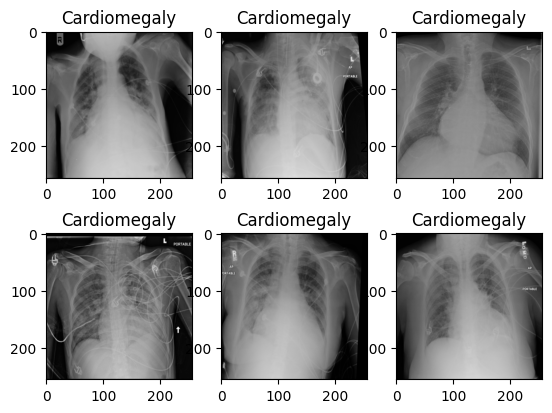

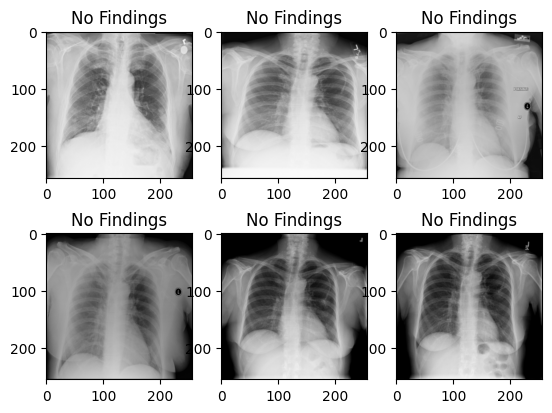

In [10]:
for idx, img in enumerate(positive_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title(finding)
  plt.imshow(positive_imgs[idx])
plt.show()

for idx, img in enumerate(negative_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title("No Findings")
  plt.imshow(negative_imgs[idx])
plt.show()

In [11]:
pre_trained_model = InceptionV3(
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), weights='imagenet', include_top=False)

for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output) #esticar imagem para dimensao 1
x = layers.Dense(1024, activation='relu')(x) #Definindo 1024 camadas ocultas, utilizando ativação relu
x = layers.Dropout(0.2)(x) # Adiciono o dropout rate de 0.2
x = layers.Dense(1, activation='sigmoid')(x) #uma saida com 1 camada, com ativação sigmoid

model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print("Done compiling the model!")

87910968/87910968 [==============================] - 0s 0us/step
Done compiling the model!


In [12]:
#Definir saidas dos exemplos nos diretorios e arquivos
base_dir = rootdir = "/content/medical-ai/images/"
train_dir = os.path.join(base_dir, finding, 'train')
test_dir = os.path.join(base_dir, finding, 'test')

train_pos_dir = os.path.join(train_dir, 'positive')
train_neg_dir = os.path.join(train_dir, 'negative')
test_pos_dir = os.path.join(test_dir, 'positive')
test_neg_dir = os.path.join(test_dir, 'negative')

In [13]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False)

# Note that the test data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

test_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

train_steps = len(os.listdir(train_pos_dir)) * 2
test_steps = len(os.listdir(test_pos_dir)) * 2

print("Done funneling data!")

Found 232 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Done funneling data!


In [15]:
history = model.fit(
      train_generator,
      steps_per_epoch=train_steps,
      epochs=20,
      validation_data=test_generator,
      validation_steps=test_steps,
      verbose=2)

Epoch 1/20
232/232 - 22s - loss: 9.4235 - acc: 0.5733 - val_loss: 1.8396 - val_acc: 0.7333 - 22s/epoch - 93ms/step
Epoch 2/20
232/232 - 9s - loss: 3.1057 - acc: 0.6078 - val_loss: 0.6380 - val_acc: 0.7167 - 9s/epoch - 39ms/step
Epoch 3/20
232/232 - 9s - loss: 0.9600 - acc: 0.6250 - val_loss: 0.6558 - val_acc: 0.6167 - 9s/epoch - 37ms/step
Epoch 4/20
232/232 - 10s - loss: 0.5876 - acc: 0.7198 - val_loss: 0.4988 - val_acc: 0.7667 - 10s/epoch - 41ms/step
Epoch 5/20
232/232 - 10s - loss: 0.5866 - acc: 0.7069 - val_loss: 0.7864 - val_acc: 0.5833 - 10s/epoch - 41ms/step
Epoch 6/20
232/232 - 11s - loss: 0.5852 - acc: 0.7629 - val_loss: 0.4987 - val_acc: 0.7000 - 11s/epoch - 46ms/step
Epoch 7/20
232/232 - 9s - loss: 0.5072 - acc: 0.7759 - val_loss: 0.7429 - val_acc: 0.6333 - 9s/epoch - 41ms/step
Epoch 8/20
232/232 - 9s - loss: 0.5178 - acc: 0.7371 - val_loss: 0.5821 - val_acc: 0.7333 - 9s/epoch - 39ms/step
Epoch 9/20
232/232 - 10s - loss: 0.6147 - acc: 0.7328 - val_loss: 0.5284 - val_acc: 0.73

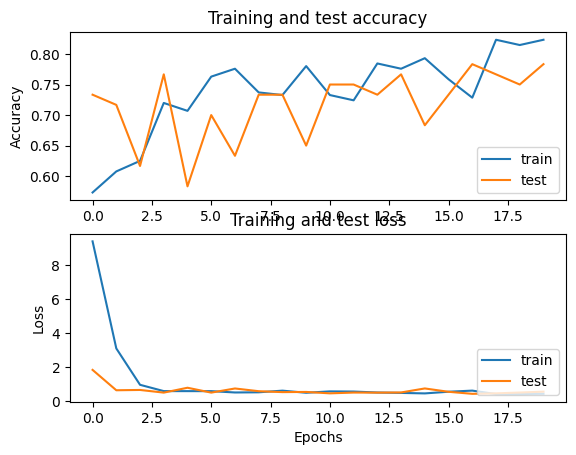

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']


loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))

plt.subplot(2,1,1)
plt.plot(epochs, acc, label="train")
plt.plot(epochs, val_acc, label="test")
plt.ylabel("Accuracy")
plt.title('Training and test accuracy')
plt.legend(loc="lower right")

plt.subplot(2,1,2)
plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and test loss')
plt.legend(loc="lower right")

plt.show()

In [33]:
def predict_image(filename):
  image = Image.open(filename).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
  image_np = load_image_into_numpy_array(image)
  exp = np.true_divide(image_np, 255.0)
  expanded = np.expand_dims(exp, axis=0)
  return model.predict(expanded)[0][0]

def show_df_row(row):
  image_path = row["filepath"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  img = load_image_into_numpy_array(image)
  exp = np.true_divide(img, 255.0)
  expanded = np.expand_dims(exp, axis=0)
  pred = model.predict(expanded)[0][0]
  guess = "neg"
  if pred > 0.5:
    guess = "pos"
  title = "Image: "+row["filename"]+" Label: "+row["label"]+" Guess: "+guess+" Score: "+str(pred)
  plt.title(title)
  plt.imshow(img)
  plt.show()
  return

In [34]:
results = []
for image in os.listdir(test_neg_dir):
  filename = test_neg_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "neg", guess, confidence])

for image in os.listdir(test_pos_dir):
  filename = test_pos_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "pos", guess, confidence])

sorted_results = sorted(results, key=lambda x: x[4], reverse=True)
df = pd.DataFrame(data=sorted_results, columns=["filepath","filename","label","guess","confidence"])

print("Done inference!")

1/1 [==============================] - 0s 25ms/step
Done inference!


In [35]:
df.head()

,filepath,filename,label,guess,confidence
0,/content/medical-ai/images/Cardiomegaly/test/p...,00013615_052.jpg,pos,pos,0.998218
1,/content/medical-ai/images/Cardiomegaly/test/p...,00025969_000.jpg,pos,pos,0.989556
2,/content/medical-ai/images/Cardiomegaly/test/p...,00004893_085.jpg,pos,pos,0.980544
3,/content/medical-ai/images/Cardiomegaly/test/p...,00010381_000.jpg,pos,pos,0.977152
4,/content/medical-ai/images/Cardiomegaly/test/p...,00005532_000.jpg,pos,pos,0.972002


1/1 [==============================] - 0s 23ms/step


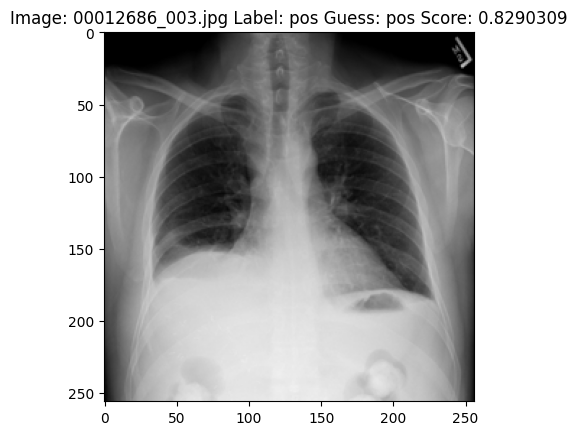

In [36]:
import random
n = random.randint(0, len(df)-1)
show_df_row(df.iloc[n])

In [21]:
df[::5][['filename', 'label', 'guess', 'confidence']]

,filename,label,guess,confidence
0,00013615_052.jpg,pos,pos,0.998218
5,00030206_013.jpg,pos,pos,0.966792
10,00000085_000.jpg,neg,pos,0.933182
15,00015304_001.jpg,pos,pos,0.898866
20,00016414_000.jpg,pos,pos,0.826825
25,00001373_039.jpg,pos,pos,0.784163
30,00000083_000.jpg,neg,pos,0.723086
35,00008522_032.jpg,pos,pos,0.567371
40,00015719_005.jpg,pos,neg,0.396961
45,00000080_002.jpg,neg,neg,0.292623


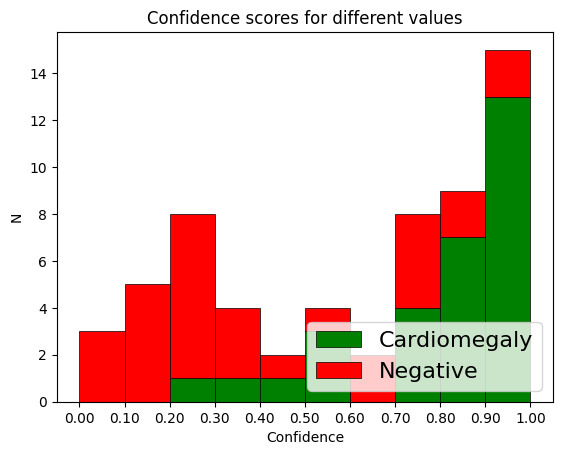

In [31]:
from matplotlib.ticker import FormatStrFormatter
pos = df.loc[df['label'] == "pos"]["confidence"]
neg = df.loc[df['label'] == "neg"]["confidence"]
fig, ax = plt.subplots()
n, bins, patches = plt.hist([pos,neg], np.arange(0.0, 1.1, 0.1).tolist(), edgecolor='black', linewidth=0.5, density=False, histtype='bar', stacked=True, color=['green', 'red'], label=[finding, 'Negative'])
plt.xlabel('Confidence')
plt.ylabel('N')
plt.xticks(bins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.title('Confidence scores for different values')
plt.legend(loc="lower right", fontsize=16)
plt.show()

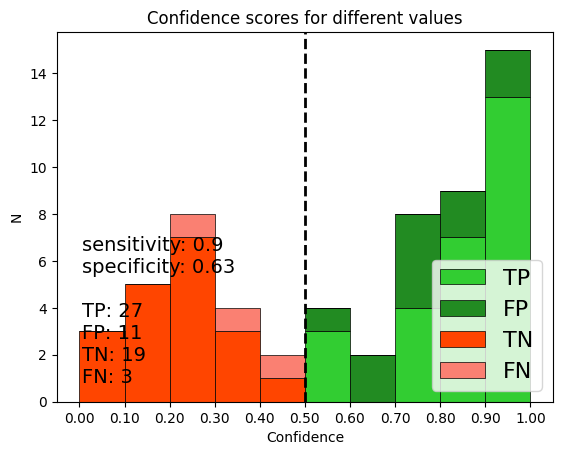

In [30]:
def create_with_custoff(custoff):
  _, ax = plt.subplots()
  TP = df.loc[(df['label'] == 'pos') & (df['confidence'] > custoff)]['confidence']
  FP = df.loc[(df['label'] == 'neg') & (df['confidence'] > custoff)]['confidence']
  TN = df.loc[(df['label'] == 'neg') & (df['confidence'] > custoff)]['confidence']
  FN = df.loc[(df['label'] == 'pos') & (df['confidence'] > custoff)]['confidence']

  plt.hist([TP, FP, TN, FN], np.arange(0.0,1.1,0.1).tolist(),histtype='bar',
            stacked=True, color=['limegreen', 'forestgreen', 'orangered', 'salmon'],
           label=['TP', 'FP', 'TN', 'FN'])

  plt.xlabel('Confidence')
  plt.ylabel('N')
  plt.ylabel(bins)
  ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.title('Confidence scores for differente images')
  plt.axvline(custoff, color='k', linestyle='dashed', linewidth=2)
  plt.legend(loc='upper right', fontsize=16)


  sens = round(len(TP)/(len(TP)+len(FN)), 2)
  spec = round(len(TN)/len(TN)+len(FP),2)

  stats = "sensitivity: "+str(sens)+"\n"+"specificity: "+str(spec)+"\n\n"+"TP: "+str(len(TP))+"\n"+"FP: "+str(len(FP))+"\n"+"TN: "+str(len(TN))+"\n"+"FN: "+str(len(FN))
  plt.text(0.05, 0.05, stats, fontsize=14, transform=ax.transAxes)
  plt.show()

create_with_cutoff(cutoff=0.5)

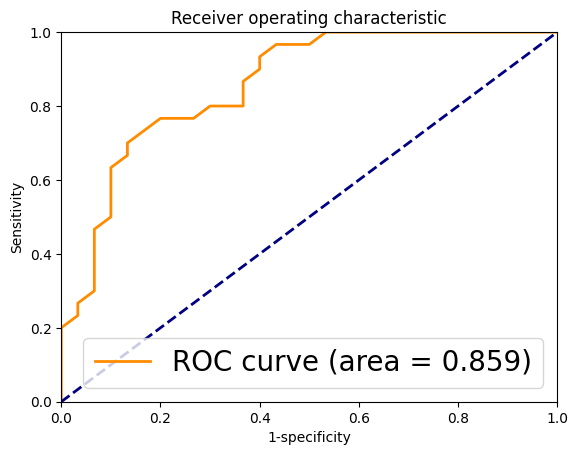

In [37]:
def create_auc_curve(classifications):
  squares = {}
  for x in classifications:
    conf = x[4]
    TP, FP, TN, FN = 0, 0, 0, 0
    for row in classifications:
      assert (row[2] == "neg" or row[2] == "pos")
      if row[2] == "neg":
        if float(row[4]) < conf: TN += 1
        else: FP += 1
      else:
        if float(row[4]) > conf: TP += 1
        else: FN += 1
    squares[conf] = [TP, FP, TN, FN]
  # now we have a list of stuff: convert to
  sens_spec = {}
  for entry in squares:
    sens = squares[entry][0] / float(squares[entry][0] + squares[entry][3])
    spec = squares[entry][2] / float(squares[entry][2] + squares[entry][1])
    sens_spec[entry] = (1-spec, sens)
  return squares, sens_spec

squares, sens_spec = create_auc_curve(sorted_results)

x = []
y = []
for point in sens_spec.keys():
  x.append(sens_spec[point][0])
  y.append(sens_spec[point][1])

auc = sklearn.metrics.auc(x, y)

plt.figure()
lw = 2
plt.plot(x, y, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Sensitivity')
plt.xlabel('1-specificity')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right", fontsize=20)
plt.show()

In [38]:
model.save('/content/export/'+finding)
!zip -r /content/{finding}.zip /content/export/{finding}

  adding: content/export/Cardiomegaly/ (stored 0%)
  adding: content/export/Cardiomegaly/saved_model.pb (deflated 92%)
  adding: content/export/Cardiomegaly/variables/ (stored 0%)
  adding: content/export/Cardiomegaly/variables/variables.index (deflated 78%)
  adding: content/export/Cardiomegaly/variables/variables.data-00000-of-00001 (deflated 49%)
  adding: content/export/Cardiomegaly/keras_metadata.pb (deflated 96%)
  adding: content/export/Cardiomegaly/fingerprint.pb (stored 0%)
  adding: content/export/Cardiomegaly/assets/ (stored 0%)
